## Ambiguous feature 지울 경우
- acc_now_delinq (Test데이터는 데이터 값이 적은 것들이 특징)
- collections_12_mths_ex_med (Test데이터는 데이터 값이 적은 것들이 특징)
- num_tl_90g_dpd_24m (Test데이터는 데이터 값이 적은 것들이 특징)
- annual_inc : (log 변환 방식을 사용) -> test와 분포를 비슷하게 만든다.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import os

import torch

import warnings
warnings.filterwarnings("ignore") 

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [5]:
###Total dataset
numbers_total_dataset = 1761129

In [6]:
## Load before 2017 data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_train_before_2017.csv"
data = pd.read_csv(data_path, low_memory=False)

In [7]:
##Drop ambiguous features
ambiguous_features = ['acc_now_delinq','collections_12_mths_ex_med']

data = data.drop(columns=ambiguous_features)

In [8]:
print(f"Train dataset the number of columns : {len(data.columns)}")

Train dataset the number of columns : 64


### Data Preprocessing

In [9]:
data['loan_status'].value_counts()

loan_status
0    1207257
1     287765
Name: count, dtype: int64

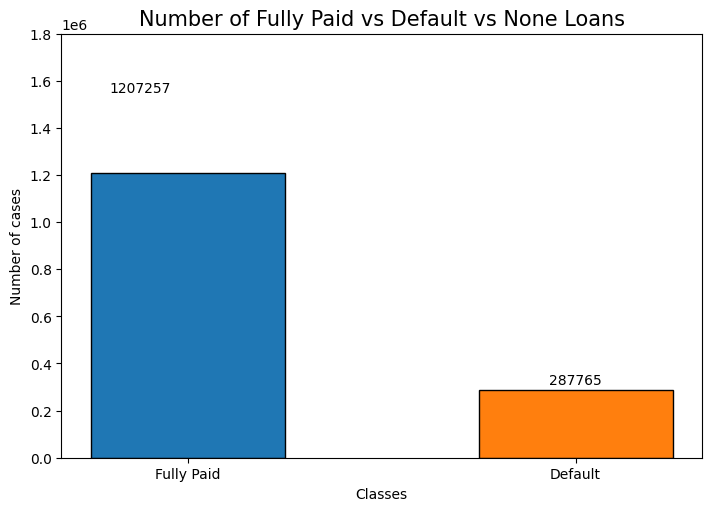

In [10]:
# Visualizing the encoded target

defalut_fully_paid = data['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Number of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
#ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

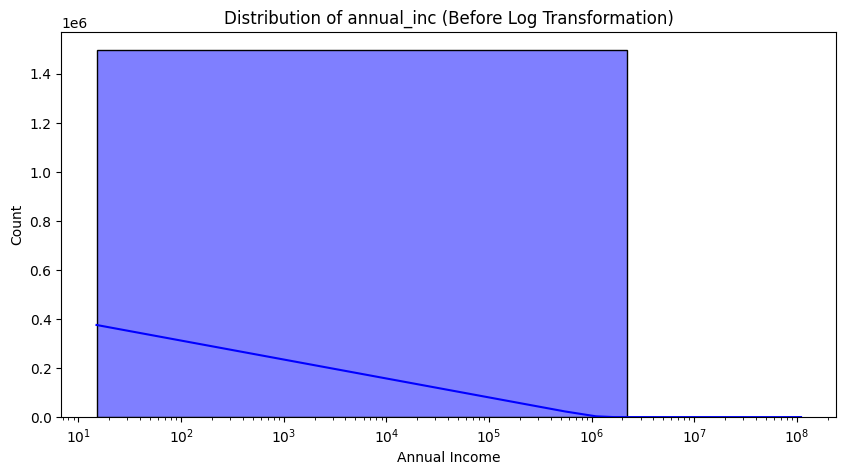

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_loan_status_distribution(data, ambiguous_features):
    fig, axes = plt.subplots(len(ambiguous_features), 2, figsize=(12, 5 * len(ambiguous_features)))
    
    for i, feature in enumerate(ambiguous_features):
        # Train Data Distribution
        sns.histplot(data[data['loan_status'] == 0][feature], bins=30, kde=True, ax=axes[i, 0], color='blue', label='loan_status 0')
        sns.histplot(data[data['loan_status'] == 1][feature], bins=30, kde=True, ax=axes[i, 0], color='red', label='loan_status 1', alpha=0.6)
        axes[i, 0].set_title(f"Train Data - {feature}")
        axes[i, 0].legend()
        
        '''# Test Data Distribution
        sns.histplot(test_data[test_data['loan_status'] == 0][feature], bins=30, kde=True, ax=axes[i, 1], color='blue', label='loan_status 0')
        sns.histplot(test_data[test_data['loan_status'] == 1][feature], bins=30, kde=True, ax=axes[i, 1], color='red', label='loan_status 1', alpha=0.6)
        axes[i, 1].set_title(f"Test Data - {feature}")
        axes[i, 1].legend()'''
    
    plt.tight_layout()
    plt.show()

def plot_annual_inc_distribution(data):
    plt.figure(figsize=(10, 5))
    sns.histplot(data['annual_inc'], bins=50, kde=True, color='blue')
    plt.title('Distribution of annual_inc (Before Log Transformation)')
    plt.xlabel('Annual Income')
    plt.ylabel('Count')
    plt.xscale('log')  # 로그 스케일 적용하여 분포 확인
    plt.show()

# Call function
plot_annual_inc_distribution(data)


### Base Modeling

In [12]:
##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_test_after_2017.csv"
test_data = pd.read_csv(test_data_path)

##Drop ambiguous features
ambiguous_features = ['acc_now_delinq','collections_12_mths_ex_med']

test_data = test_data.drop(columns=ambiguous_features)

print(f"Test dataset the number of columns : {len(test_data.columns)}")

Test dataset the number of columns : 64


In [13]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

### LabelEncoding

In [14]:
# 4️⃣ Label Encoding
label_encoders = {}

# 🔹 data_x: 범주형(Object) 컬럼만 Label Encoding
for col in data_x.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_x[col] = le.fit_transform(data_x[col].astype(str))  # NaN 대비 문자열 변환
    label_encoders[col] = le  # 필요하면 디코딩 가능

# 🔹 data_y: loan_status도 Label Encoding
le_y = LabelEncoder()
data_y['loan_status'] = le_y.fit_transform(data_y['loan_status'].astype(str))

# 5️⃣ 변환된 데이터 확인
print("Encoded data_x sample:\n", data_x.head())
print("Encoded data_y sample:\n", data_y.head())

# 🔹 Test 데이터 Encoding 적용
X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

# ✅ Train에서 학습한 LabelEncoder로 변환 (fit_transform() ❌ → transform() ✅)
for col in X_test.select_dtypes(include=['object']).columns:
    if col in label_encoders:  # Train에서 학습한 LabelEncoder가 존재하는 경우
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

# ✅ y_test도 Train에서 학습한 LabelEncoder 적용
y_test['loan_status'] = le_y.transform(y_test['loan_status'].astype(str))

# ✅ 변환된 데이터 확인
print("Encoded X_test sample:\n", X_test.head())
print("Encoded y_test sample:\n", y_test.head())

Encoded data_x sample:
    loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0    12000.0      12000.0          12000.0     0     10.99       392.81   
1     4800.0       4800.0           4800.0     0     10.99       157.13   
2    27050.0      27050.0          27050.0     0     10.99       885.46   
3    12000.0      12000.0          12000.0     0      7.62       373.94   
4    14000.0      14000.0          14000.0     0     12.85       470.71   

   grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
0      1          6               5     60000.0  ...           100.0   
1      1          6               1     39600.0  ...           100.0   
2      1          6               4     55000.0  ...           100.0   
3      0          2               1     96500.0  ...           100.0   
4      1          8               5     88000.0  ...            78.6   

   percent_bc_gt_75  pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  \
0               0.0

### Split Train - Validation

In [15]:
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/numbers_total_dataset:.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/numbers_total_dataset:.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/numbers_total_dataset:.1%})")

Train size: 1196017 samples (67.9%)
Validation size: 299005 samples (17.0%)
Test size: 266107 samples (15.1%)


### Min-Max Scailing

In [16]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

Scaled data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
1406896   0.230769     0.230769         0.235182   0.0  0.415660     0.202111   
1267104   0.128205     0.128205         0.133206   0.0  0.238411     0.112403   
661712    0.692308     0.692308         0.694073   0.0  0.035840     0.495621   
703097    0.846154     0.846154         0.847036   0.0  0.363459     0.681019   
1214333   0.064103     0.064103         0.069471   0.0  0.291001     0.065689   

            grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
1406896  0.333333   0.411765             1.0    0.000482  ...             1.0   
1267104  0.166667   0.235294             1.0    0.000454  ...             1.0   
661712   0.000000   0.029412             0.2    0.000682  ...             1.0   
703097   0.333333   0.411765             0.2    0.001818  ...             1.0   
1214333  0.333333   0.294118             0.8    0.000582  ...             1.0   

   

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

"""pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
scale_pos_weight = neg / pos  # 클래스 비율 계산"""

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    ##scale_pos_weight=scale_pos_weight, 
    n_estimators=300,
    learning_rate=0.005,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

[0]	validation_0-logloss:0.49228	validation_1-logloss:0.49281
[1]	validation_0-logloss:0.49140	validation_1-logloss:0.49234
[2]	validation_0-logloss:0.49054	validation_1-logloss:0.49186
[3]	validation_0-logloss:0.49016	validation_1-logloss:0.49201
[4]	validation_0-logloss:0.48931	validation_1-logloss:0.49170
[5]	validation_0-logloss:0.48895	validation_1-logloss:0.49183
[6]	validation_0-logloss:0.48812	validation_1-logloss:0.49139
[7]	validation_0-logloss:0.48730	validation_1-logloss:0.49106
[8]	validation_0-logloss:0.48650	validation_1-logloss:0.49078
[9]	validation_0-logloss:0.48571	validation_1-logloss:0.49051
[10]	validation_0-logloss:0.48493	validation_1-logloss:0.49004
[11]	validation_0-logloss:0.48416	validation_1-logloss:0.48959
[12]	validation_0-logloss:0.48340	validation_1-logloss:0.48916
[13]	validation_0-logloss:0.48265	validation_1-logloss:0.48894
[14]	validation_0-logloss:0.48191	validation_1-logloss:0.48876
[15]	validation_0-logloss:0.48118	validation_1-logloss:0.48862
[1

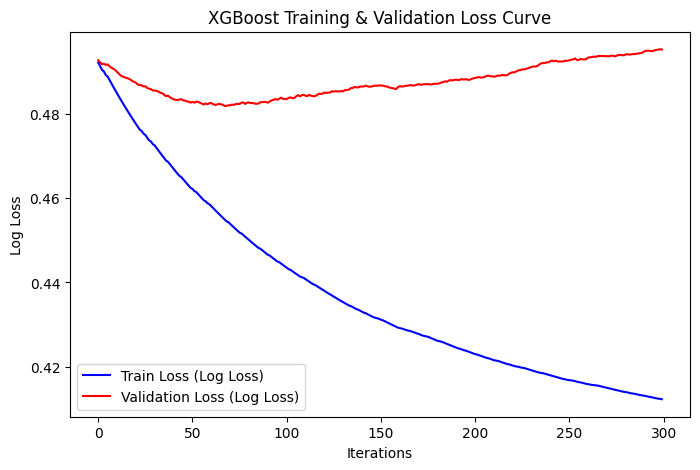

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    208044
           1       1.00      0.10      0.18     58063

    accuracy                           0.80    266107
   macro avg       0.90      0.55      0.53    266107
weighted avg       0.84      0.80      0.73    266107



In [18]:
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

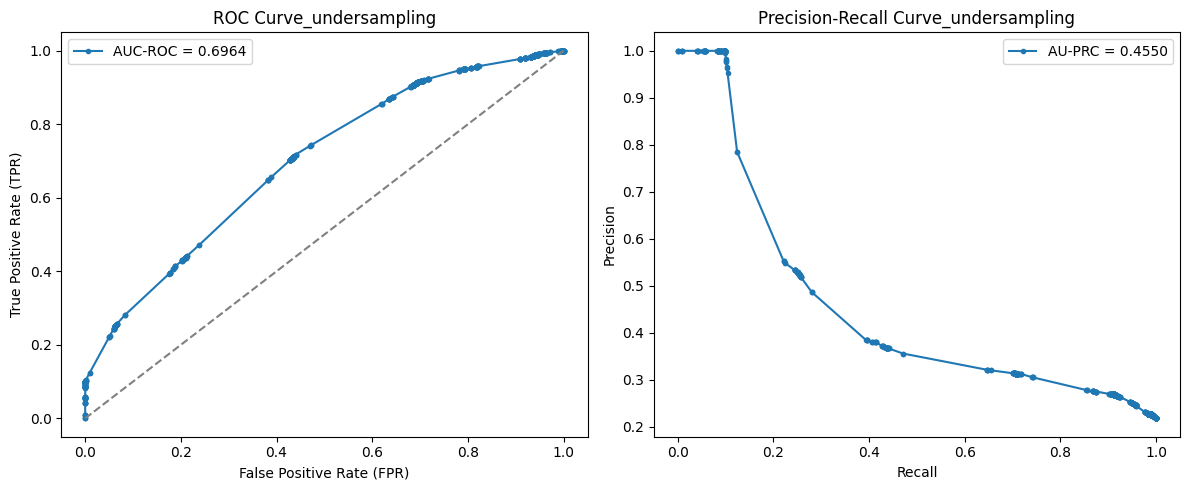

In [19]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

### OverSampling SMOTE-NC

In [20]:
##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_test_after_2017.csv"
test_data = pd.read_csv(test_data_path)

##Drop ambiguous features
ambiguous_features = ['acc_now_delinq','collections_12_mths_ex_med']

test_data = test_data.drop(columns=ambiguous_features)

print(f"Test dataset the number of columns : {len(test_data.columns)}")

Test dataset the number of columns : 64


In [21]:
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/smotenc_data.csv"
augmentation_data = pd.read_csv(data_path)

##Drop ambiguous features
ambiguous_features = ['acc_now_delinq','collections_12_mths_ex_med']

augmentation_data = augmentation_data.drop(columns=ambiguous_features)

print(f"Test dataset the number of columns : {len(augmentation_data.columns)}")

Test dataset the number of columns : 64


In [22]:
X_train_smotenc = augmentation_data.drop(columns='loan_status')
y_train_smotenc = augmentation_data[['loan_status']]

### LabelEncoding

In [23]:
# 4️⃣ Label Encoding (Train 데이터)
label_encoders = {}

# 🔹 X_train_smotenc: 범주형(Object) 컬럼 Label Encoding
for col in X_train_smotenc.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train_smotenc[col] = le.fit_transform(X_train_smotenc[col].astype(str))  # NaN 대비 문자열 변환
    label_encoders[col] = le  # 필요하면 디코딩 가능

# 🔹 y_train_smotenc: loan_status도 Label Encoding
le_y = LabelEncoder()
y_train_smotenc['loan_status'] = le_y.fit_transform(y_train_smotenc['loan_status'].astype(str))

# 5️⃣ 변환된 데이터 확인
print("Encoded X_train_smotenc sample:\n", X_train_smotenc.head())
print("Encoded y_train_smotenc sample:\n", y_train_smotenc.head())

# 🔹 Test 데이터 Encoding 적용
X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

# ✅ Train에서 학습한 LabelEncoder로 변환 (fit_transform() ❌ → transform() ✅)
for col in X_test.select_dtypes(include=['object']).columns:
    if col in label_encoders:  # Train에서 학습한 LabelEncoder가 존재하는 경우
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

# ✅ y_test도 Train에서 학습한 LabelEncoder 적용
y_test['loan_status'] = le_y.transform(y_test['loan_status'].astype(str))

# ✅ 변환된 데이터 확인
print("Encoded X_test sample:\n", X_test.head())
print("Encoded y_test sample:\n", y_test.head())

Encoded X_train_smotenc sample:
    loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0    12000.0      12000.0          12000.0     0     10.99       392.81   
1     4800.0       4800.0           4800.0     0     10.99       157.13   
2    27050.0      27050.0          27050.0     0     10.99       885.46   
3    12000.0      12000.0          12000.0     0      7.62       373.94   
4    14000.0      14000.0          14000.0     0     12.85       470.71   

   grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
0      1          6               5     60000.0  ...           100.0   
1      1          6               1     39600.0  ...           100.0   
2      1          6               4     55000.0  ...           100.0   
3      0          2               1     96500.0  ...           100.0   
4      1          8               5     88000.0  ...            78.6   

   percent_bc_gt_75  pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  \
0         

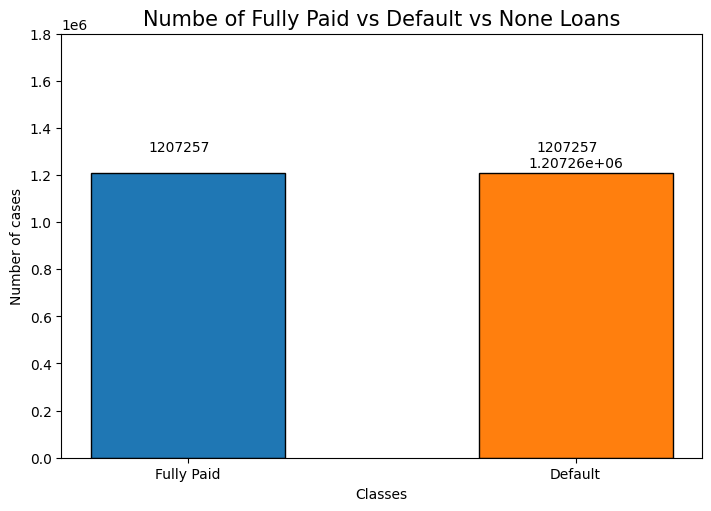

In [24]:
# Visualizing the encoded target

defalut_fully_paid = y_train_smotenc.value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.8,1300000,defalut_fully_paid[0])
ax.text(3.8,1300000,defalut_fully_paid[1])

fig.show()

### Split train-validation

In [25]:
# data under 6:2:2 train,val,test set 
X_train, X_val, y_train, y_val = train_test_split(X_train_smotenc, y_train_smotenc, test_size=0.2, random_state=42, stratify=y_train_smotenc)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(augmentation_data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(augmentation_data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(augmentation_data):.1%})")

Train size: 1931611 samples (80.0%)
Validation size: 482903 samples (20.0%)
Test size: 266107 samples (11.0%)


### Min - Max Scaling

In [26]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)

scaler_fitted = scaler

Scaled data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
1044693   0.871795     0.871795         0.872530   0.0  0.174523     0.653764   
1060167   0.153846     0.153846         0.158700   0.0  0.240358     0.131710   
2335757   0.358974     0.358974         0.362054   0.0  0.365777     0.293218   
2015114   0.335423     0.335423         0.339235   1.0  0.690352     0.236541   
1332635   0.230769     0.230769         0.235182   0.0  0.084534     0.178489   

            grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
1044693  0.166667   0.205882             0.2    0.002587  ...        1.000000   
1060167  0.166667   0.264706             0.8    0.001248  ...        1.000000   
2335757  0.333333   0.411765             1.0    0.001425  ...        0.993494   
2015114  0.666667   0.823529             1.0    0.001985  ...        1.000000   
1332635  0.000000   0.088235             0.8    0.002154  ...        0.900000   

   

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

"""pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
scale_pos_weight = neg / pos  # 클래스 비율 계산"""

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=300,
    learning_rate=0.005,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

[0]	validation_0-logloss:0.69101	validation_1-logloss:0.69281
[1]	validation_0-logloss:0.68912	validation_1-logloss:0.69275
[2]	validation_0-logloss:0.68700	validation_1-logloss:0.69276
[3]	validation_0-logloss:0.68520	validation_1-logloss:0.69261
[4]	validation_0-logloss:0.68308	validation_1-logloss:0.69229
[5]	validation_0-logloss:0.68105	validation_1-logloss:0.69208
[6]	validation_0-logloss:0.67908	validation_1-logloss:0.69212
[7]	validation_0-logloss:0.67707	validation_1-logloss:0.69180
[8]	validation_0-logloss:0.67524	validation_1-logloss:0.69175
[9]	validation_0-logloss:0.67328	validation_1-logloss:0.69156
[10]	validation_0-logloss:0.67142	validation_1-logloss:0.69121
[11]	validation_0-logloss:0.66941	validation_1-logloss:0.69090
[12]	validation_0-logloss:0.66750	validation_1-logloss:0.69070
[13]	validation_0-logloss:0.66553	validation_1-logloss:0.69040
[14]	validation_0-logloss:0.66405	validation_1-logloss:0.69039
[15]	validation_0-logloss:0.66246	validation_1-logloss:0.69035
[1

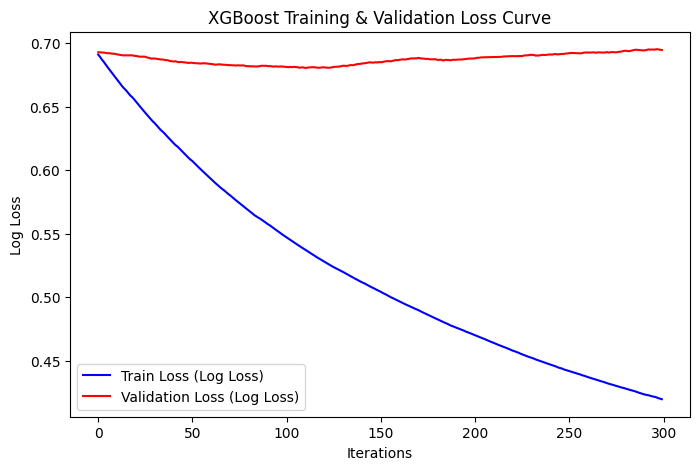

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.10      0.18    208044
           1       0.22      0.91      0.35     58063

    accuracy                           0.28    266107
   macro avg       0.51      0.50      0.27    266107
weighted avg       0.67      0.28      0.22    266107



In [28]:
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

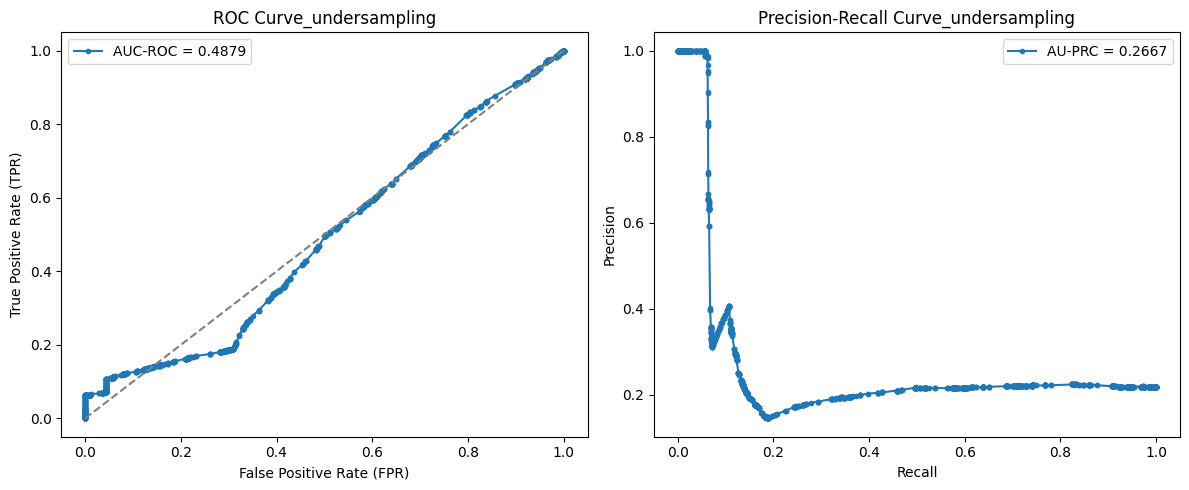

In [29]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

<Figure size 1000x800 with 0 Axes>

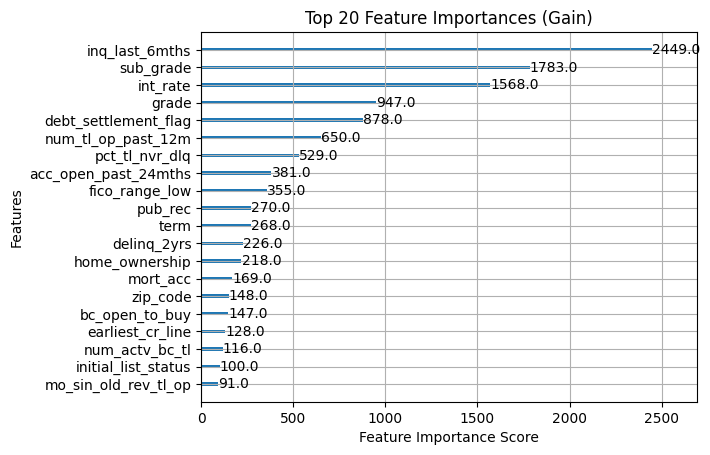

In [30]:
###xgboost feature gain 확인
import xgboost as xgb
# 8️⃣ Feature Importance 추출 및 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(
    model,
    importance_type='weight',  # 중요도 계산 방법: 'weight', 'gain', 'cover' 중 선택 가능
    max_num_features=20,     # 상위 20개 feature만 표시
    xlabel='Feature Importance Score',
    title='Top 20 Feature Importances (Gain)',
    grid=True
)
plt.show()

### UnderSampling

In [31]:
## Load before 2017 data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_train_before_2017.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_test_after_2017.csv"
test_data = pd.read_csv(test_data_path)

##Drop ambiguous features
ambiguous_features = ['acc_now_delinq','collections_12_mths_ex_med']

data = data.drop(columns=ambiguous_features)
test_data = test_data.drop(columns=ambiguous_features)

print(f"Train dataset the number of columns : {len(data.columns)}\nTest dataset the number of columns : {len(test_data.columns)}")

Train dataset the number of columns : 64
Test dataset the number of columns : 64


In [32]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns = "loan_status")
y_test = test_data[['loan_status']]

### LabelEncoding

In [33]:
# 4️⃣ Label Encoding
label_encoders = {}

# 🔹 data_x: 범주형(Object) 컬럼만 Label Encoding
for col in data_x.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_x[col] = le.fit_transform(data_x[col].astype(str))  # NaN 대비 문자열 변환
    label_encoders[col] = le  # 필요하면 디코딩 가능

# 🔹 data_y: loan_status도 Label Encoding
le_y = LabelEncoder()
data_y['loan_status'] = le_y.fit_transform(data_y['loan_status'].astype(str))

# 5️⃣ 변환된 데이터 확인
print("Encoded data_x sample:\n", data_x.head())
print("Encoded data_y sample:\n", data_y.head())

# 🔹 Test 데이터 Encoding 적용
X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

# ✅ Train에서 학습한 LabelEncoder로 변환 (fit_transform() ❌ → transform() ✅)
for col in X_test.select_dtypes(include=['object']).columns:
    if col in label_encoders:  # Train에서 학습한 LabelEncoder가 존재하는 경우
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

# ✅ y_test도 Train에서 학습한 LabelEncoder 적용
y_test['loan_status'] = le_y.transform(y_test['loan_status'].astype(str))

# ✅ 변환된 데이터 확인
print("Encoded X_test sample:\n", X_test.head())
print("Encoded y_test sample:\n", y_test.head())

Encoded data_x sample:
    loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0    12000.0      12000.0          12000.0     0     10.99       392.81   
1     4800.0       4800.0           4800.0     0     10.99       157.13   
2    27050.0      27050.0          27050.0     0     10.99       885.46   
3    12000.0      12000.0          12000.0     0      7.62       373.94   
4    14000.0      14000.0          14000.0     0     12.85       470.71   

   grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
0      1          6               5     60000.0  ...           100.0   
1      1          6               1     39600.0  ...           100.0   
2      1          6               4     55000.0  ...           100.0   
3      0          2               1     96500.0  ...           100.0   
4      1          8               5     88000.0  ...            78.6   

   percent_bc_gt_75  pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  \
0               0.0

#### Undersample

In [34]:
# 클래스별 샘플 개수 확인
print("Original class distribution:\n", data_y.value_counts())

# 언더샘플링 적용 (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(data_x, data_y)

# 결과 확인 (각 데이터셋 크기)
print(f"Original data size: {data_x.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# 데이터프레임 변환 (필요하면)
data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# 언더샘플링 및 오버샘플링 결과 확인
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")

Original class distribution:
 loan_status
0              1207257
1               287765
Name: count, dtype: int64
Original data size: 1495022 samples
Undersampled data size: 575530 samples

Undersampling imbalance check
loan_status
0    287765
1    287765
Name: count, dtype: int64


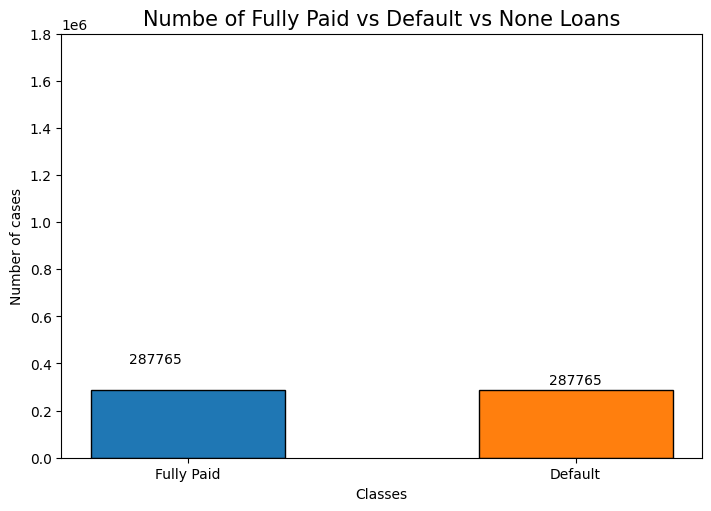

In [35]:
# Visualizing the encoded target

defalut_fully_paid = data_under['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.7,400000,defalut_fully_paid[0])
# ax.text(5.6,1150000,none_)

fig.show()

In [36]:
data_x = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
data_y = data_under[['loan_status']]  # Target (타겟 변수)

In [37]:
# data under 6:2:2 train,val,test set

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data_under):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data_under):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data_under):.1%})")

Train size: 460424 samples (80.0%)
Validation size: 115106 samples (20.0%)
Test size: 266107 samples (46.2%)


### Min-Max Scaling

In [38]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

Scaled data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
819346    0.205128     0.205128         0.207161   0.0  0.181924     0.162430   
1071330   0.512821     0.512821         0.514066   0.0  0.239579     0.398605   
20448     0.307692     0.307692         0.309463   0.0  0.325282     0.251685   
497800    0.118590     0.118590         0.120844   0.0  0.220880     0.099988   
734304    0.615385     0.615385         0.616368   0.0  0.100117     0.451473   

            grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
819346   0.166667   0.205882             1.0    0.014623  ...           0.846   
1071330  0.166667   0.264706             0.2    0.022980  ...           0.941   
20448    0.166667   0.264706             0.2    0.004699  ...           0.921   
497800   0.166667   0.176471             1.0    0.005221  ...           0.857   
734304   0.000000   0.117647             1.0    0.009004  ...           1.000   

   

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

"""pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
scale_pos_weight = neg / pos  # 클래스 비율 계산"""

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=300,
    learning_rate=0.005,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

[0]	validation_0-logloss:0.69217	validation_1-logloss:0.69282
[1]	validation_0-logloss:0.69120	validation_1-logloss:0.69215
[2]	validation_0-logloss:0.69024	validation_1-logloss:0.69149
[3]	validation_0-logloss:0.68965	validation_1-logloss:0.69154
[4]	validation_0-logloss:0.68870	validation_1-logloss:0.69108
[5]	validation_0-logloss:0.68813	validation_1-logloss:0.69075
[6]	validation_0-logloss:0.68720	validation_1-logloss:0.69013
[7]	validation_0-logloss:0.68627	validation_1-logloss:0.68980
[8]	validation_0-logloss:0.68537	validation_1-logloss:0.68961
[9]	validation_0-logloss:0.68447	validation_1-logloss:0.68897
[10]	validation_0-logloss:0.68357	validation_1-logloss:0.68849
[11]	validation_0-logloss:0.68269	validation_1-logloss:0.68787
[12]	validation_0-logloss:0.68181	validation_1-logloss:0.68739
[13]	validation_0-logloss:0.68094	validation_1-logloss:0.68692
[14]	validation_0-logloss:0.68007	validation_1-logloss:0.68635
[15]	validation_0-logloss:0.67922	validation_1-logloss:0.68580
[1

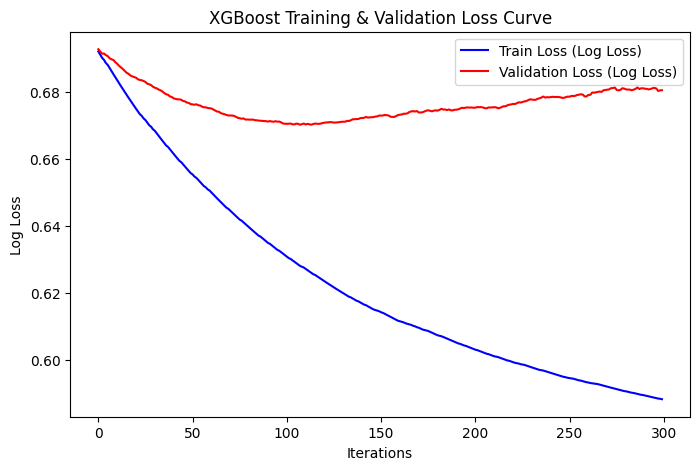

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.07      0.13    208044
           1       0.23      0.98      0.37     58063

    accuracy                           0.27    266107
   macro avg       0.58      0.53      0.25    266107
weighted avg       0.78      0.27      0.18    266107



In [40]:
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

'''threshold = 0.3
y_pred_adjusted = (y_prob>threshold).astype(int)'''

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

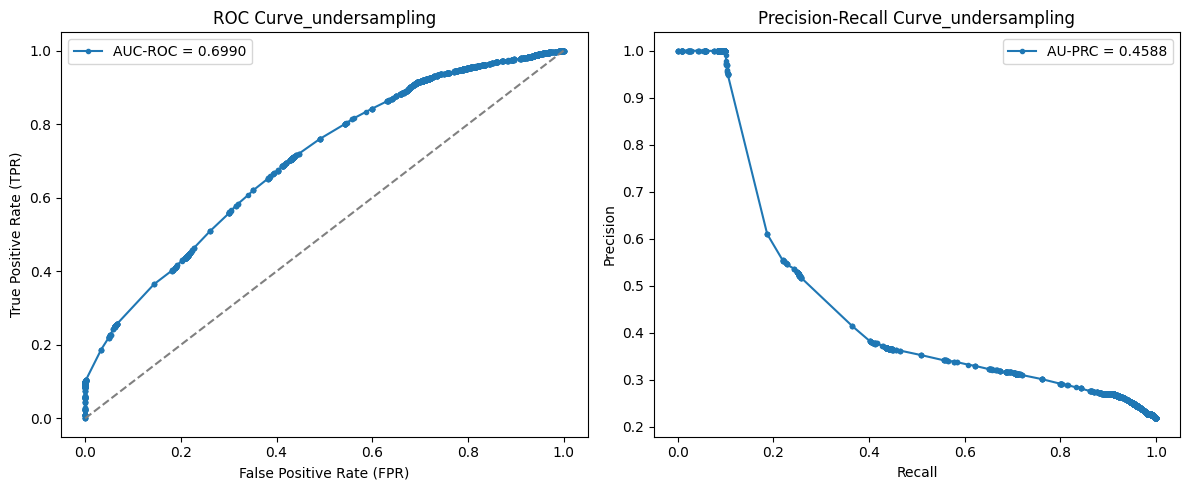

In [41]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

<Figure size 1000x800 with 0 Axes>

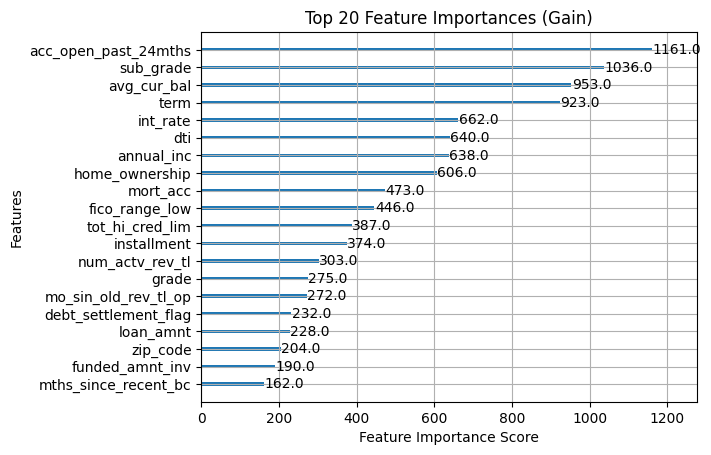

In [42]:
###xgboost feature gain 확인
import xgboost as xgb
# 8️⃣ Feature Importance 추출 및 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(
    model,
    importance_type='weight',  # 중요도 계산 방법: 'weight', 'gain', 'cover' 중 선택 가능
    max_num_features=20,     # 상위 20개 feature만 표시
    xlabel='Feature Importance Score',
    title='Top 20 Feature Importances (Gain)',
    grid=True
)
plt.show()

### TableGan

In [43]:
## Load before 2017 data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_train_before_2017.csv"
data = pd.read_csv(data_path, low_memory=False)

In [44]:
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/train/train_custom_fake.csv"
fake = pd.read_csv(fake_path)

fake['loan_status'] = 1

In [45]:
from sklearn.utils import shuffle

train_total = pd.concat([data,fake])
train_total = shuffle(train_total, random_state=42)

In [46]:
##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/defalut_original_test_after_2017.csv"
test_data = pd.read_csv(test_data_path)

##Drop ambiguous features
ambiguous_features = ['acc_now_delinq','collections_12_mths_ex_med']

train_total = train_total.drop(columns=ambiguous_features)
test_data = test_data.drop(columns=ambiguous_features)

print(f"Train dataset the number of columns : {len(train_total.columns)}\nTest dataset the number of columns : {len(test_data.columns)}")

Train dataset the number of columns : 64
Test dataset the number of columns : 64


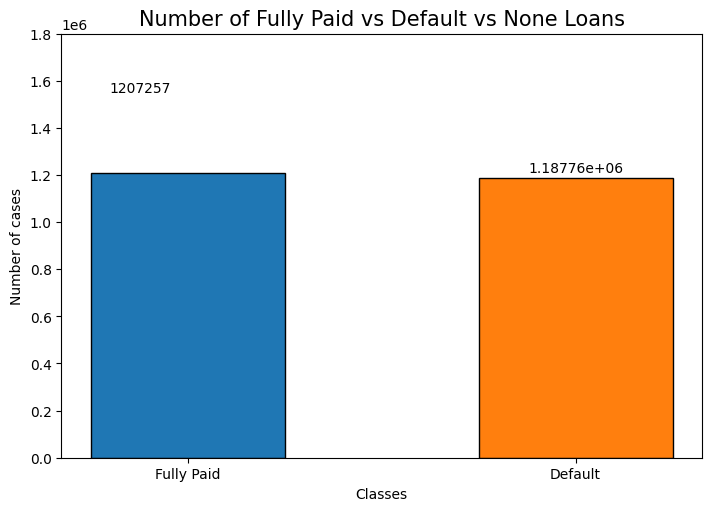

In [47]:
# Visualizing the encoded target

defalut_fully_paid = train_total['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Number of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
#ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

In [48]:
data_x = train_total.drop(columns='loan_status')
data_y = train_total[['loan_status']]

X_test = test_data.drop(columns = "loan_status")
y_test = test_data[['loan_status']]

In [49]:
# 4️⃣ Label Encoding
label_encoders = {}

# 🔹 data_x: 범주형(Object) 컬럼만 Label Encoding
for col in data_x.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_x[col] = le.fit_transform(data_x[col].astype(str))  # NaN 대비 문자열 변환
    label_encoders[col] = le  # 필요하면 디코딩 가능

# 🔹 data_y: loan_status도 Label Encoding
le_y = LabelEncoder()
data_y['loan_status'] = le_y.fit_transform(data_y['loan_status'].astype(str))

# 5️⃣ 변환된 데이터 확인
print("Encoded data_x sample:\n", data_x.head())
print("Encoded data_y sample:\n", data_y.head())

# 🔹 Test 데이터 Encoding 적용
X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

# ✅ Train에서 학습한 LabelEncoder로 변환 (fit_transform() ❌ → transform() ✅)
for col in X_test.select_dtypes(include=['object']).columns:
    if col in label_encoders:  # Train에서 학습한 LabelEncoder가 존재하는 경우
        X_test[col] = label_encoders[col].transform(X_test[col].astype(str))

# ✅ y_test도 Train에서 학습한 LabelEncoder 적용
y_test['loan_status'] = le_y.transform(y_test['loan_status'].astype(str))

# ✅ 변환된 데이터 확인
print("Encoded X_test sample:\n", X_test.head())
print("Encoded y_test sample:\n", y_test.head())

Encoded data_x sample:
         loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
737365     4400.0       4400.0           4400.0     0     15.61       153.85   
594041    27000.0      27000.0          27000.0     1     14.33       632.88   
93302      5900.0       6000.0           5925.0     1     14.33       240.45   
125601     6650.0       6300.0           6350.0     1     19.89       224.47   
802378    11600.0      11450.0          10950.0     1     17.76       256.05   

        grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
737365      3         15               1     39416.0  ...           100.0   
594041      2         14               4     54000.0  ...           100.0   
93302       3          6               1      7920.0  ...           100.0   
125601      4         22               1     37044.8  ...            87.8   
802378      1         15               1     51365.0  ...            91.5   

        percent_bc_gt_75  pub_re

In [50]:
# data under 6:2:2 train,val,test set

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(train_total):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(train_total):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(train_total):.1%})")

Train size: 1916017 samples (80.0%)
Validation size: 479005 samples (20.0%)
Test size: 266107 samples (11.1%)


In [51]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

Scaled data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
195906    0.064103     0.064103         0.068878   0.0  0.160499     0.062447   
172351    0.158974     0.158974         0.163265   0.0  0.458512     0.147006   
271043    0.115385     0.115385         0.119898   0.0  0.000000     0.093714   
1386163   0.358974     0.358974         0.362245   1.0  0.240358     0.189451   
1315909   0.615385     0.615385         0.617347   1.0  0.142968     0.299673   

            grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
195906   0.166667   0.147059             0.2    0.000809  ...           0.977   
172351   0.500000   0.441176             1.0    0.000682  ...           1.000   
271043   0.000000   0.000000             0.2    0.000909  ...           1.000   
1386163  0.166667   0.264706             0.2    0.000727  ...           1.000   
1315909  0.166667   0.147059             0.8    0.001200  ...           0.870   

   

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

"""pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
scale_pos_weight = neg / pos  # 클래스 비율 계산"""

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=300,
    learning_rate=0.005,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

[0]	validation_0-logloss:0.68970	validation_1-logloss:0.69129
[1]	validation_0-logloss:0.68631	validation_1-logloss:0.68969
[2]	validation_0-logloss:0.68296	validation_1-logloss:0.68757
[3]	validation_0-logloss:0.67985	validation_1-logloss:0.68616
[4]	validation_0-logloss:0.67657	validation_1-logloss:0.68467
[5]	validation_0-logloss:0.67353	validation_1-logloss:0.68248
[6]	validation_0-logloss:0.67030	validation_1-logloss:0.68229
[7]	validation_0-logloss:0.66712	validation_1-logloss:0.68075
[8]	validation_0-logloss:0.66396	validation_1-logloss:0.68011
[9]	validation_0-logloss:0.66083	validation_1-logloss:0.67889
[10]	validation_0-logloss:0.65772	validation_1-logloss:0.67713
[11]	validation_0-logloss:0.65465	validation_1-logloss:0.67629
[12]	validation_0-logloss:0.65161	validation_1-logloss:0.67374
[13]	validation_0-logloss:0.64859	validation_1-logloss:0.67203
[14]	validation_0-logloss:0.64561	validation_1-logloss:0.67068
[15]	validation_0-logloss:0.64265	validation_1-logloss:0.66927
[1

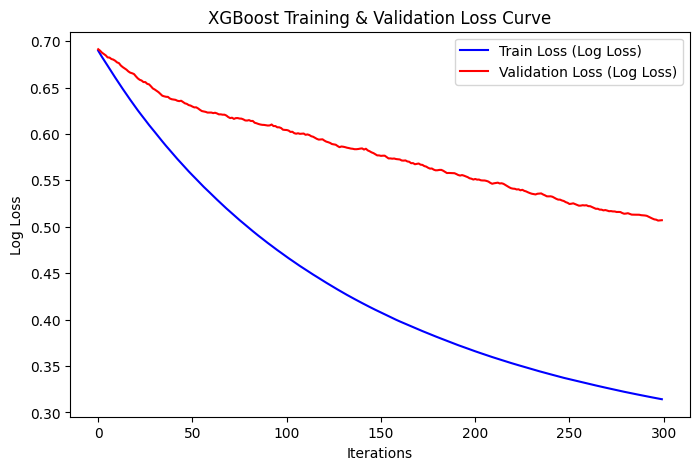

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    208044
           1       0.99      0.10      0.18     58063

    accuracy                           0.80    266107
   macro avg       0.89      0.55      0.53    266107
weighted avg       0.84      0.80      0.73    266107



In [53]:
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

'''threshold = 0.3
y_pred_adjusted = (y_prob>threshold).astype(int)'''

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

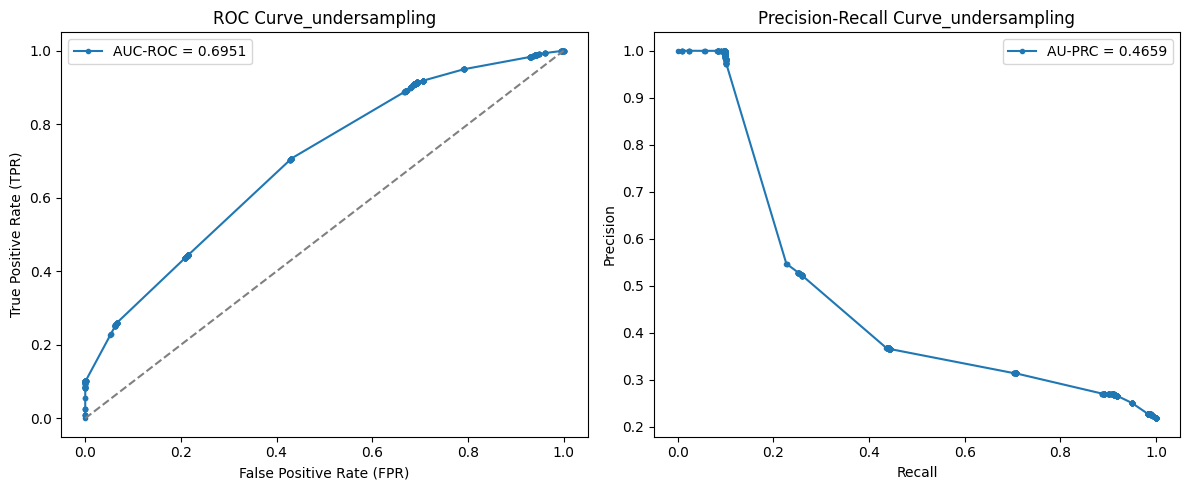

In [54]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

<Figure size 1000x800 with 0 Axes>

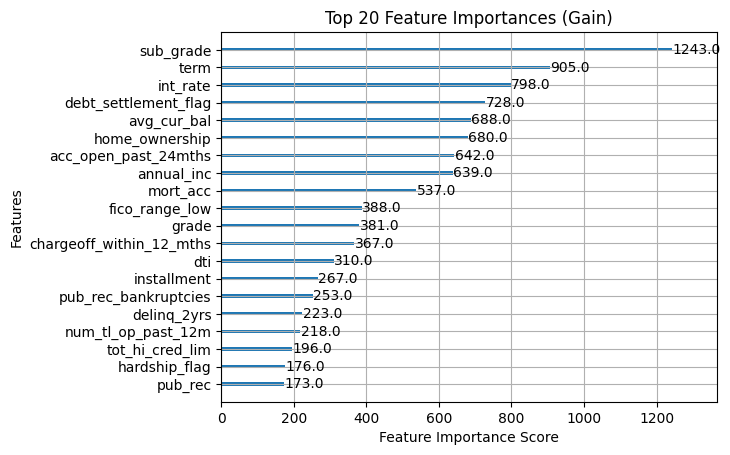

In [55]:
###xgboost feature gain 확인
import xgboost as xgb
# 8️⃣ Feature Importance 추출 및 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(
    model,
    importance_type='weight',  # 중요도 계산 방법: 'weight', 'gain', 'cover' 중 선택 가능
    max_num_features=20,     # 상위 20개 feature만 표시
    xlabel='Feature Importance Score',
    title='Top 20 Feature Importances (Gain)',
    grid=True
)
plt.show()

In [ ]:
# IQR 이상치 제거
Q1 = data['annual_inc'].quantile(0.25)
Q3 = data['annual_inc'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data['annual_inc'] >= lower_bound) & (data['annual_inc'] <= upper_bound)]

# 로그 변환
data['annual_inc'] = np.log1p(data['annual_inc'])
test_data['annual_inc'] = np.log1p(test_data['annual_inc'])
